In [16]:
%load_ext autoreload
%autoreload 2

from __future__ import print_function
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR

from numpy import cos, sin, arange, trace, pi, newaxis, sum, eye, array, mgrid, diag, prod
from numpy.linalg import norm, matrix_power
from numpy.random import randn, rand, seed
import numpy as np

from matplotlib.pyplot import figure, plot, xlabel, ylabel, title, legend, show, xlim, ylim, subplot, grid, savefig, imshow, colorbar, tight_layout, text, xticks, yticks, yscale


from data import FixedRot, Reshape
from trainer import Trainer
from model import Lconv_core


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Ground Truth

In [17]:
shift = Q = lambda d,z: sum([1/d * cos(2*pi*p/d *z) for p in arange(-d/2+1,d/2)], axis=0)
L0 = lambda d,z: sum([-2*pi*p/d**2 * sin(2*pi*p/d *z) for p in arange(-d/2+1,d/2)], axis=0)

# cosine correlation 
coscorr = lambda x,y: trace(x.T@y)/norm(x)/norm(y)

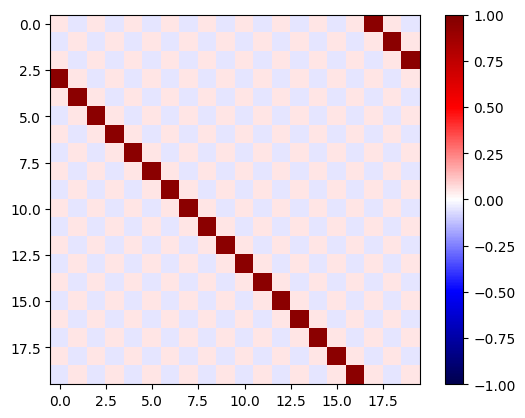

In [18]:
d = 20
m = 3
z = arange(d)[:,newaxis]-arange(d)
imshow(Q(d,z-m), cmap = 'seismic',vmin=-1, vmax=1)
colorbar()

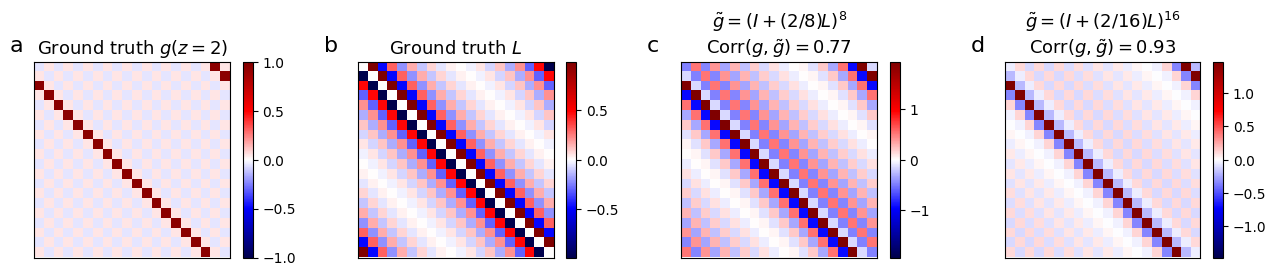

In [19]:
d = 20
m = 2
ns = array([4,8])*m
labs = '0abcde'

mx = 2
z = arange(d)[:,newaxis]-arange(d)
ii=0
figure(figsize=(13,2.7))
ii+=1
subplot(1,len(ns)+2,ii)
text(-3,-1.5,labs[ii], fontdict={'size':16,'weight':1})

a=Q(d,z-m)
mx=max(abs(a.ravel()))
imshow(a, cmap = 'seismic',vmin=-1, vmax=1)
colorbar()
title(r'Ground truth $g(z=%d)$'%m, size=13)
xticks([])
yticks([])

ii+=1
subplot(1,len(ns)+2,ii)
text(-4,-1.5,labs[ii], fontdict={'size':16,'weight':1})

a=L0(d,z)
mx=max(abs(a.ravel()))
imshow(a, cmap = 'seismic',vmin=-mx, vmax=mx)
colorbar()
title(r'Ground truth $L$',size=13)
xticks([])
yticks([])


for n in ns:
    ii+=1
    subplot(1,len(ns)+2,ii)
    text(-4,-1.5,labs[ii], fontdict={'size':16,'weight':1})

    a=matrix_power(eye(d)-m/n* L0(d,z),n)
    mx = max(abs(a.ravel()))
    imshow(a, cmap = 'seismic',vmin=-mx, vmax=mx)
    colorbar()
#     overlap = trace(a.T@Q(d,z-m))/norm(a)/norm(Q(d,z-m))
    overlap = coscorr(a,Q(d,z-m))
    title(r'$\tilde{g}=(I+(%d/%d)L)^{%d}$'%(m,n,n)+'\nCorr'+r'$(g,\tilde{g})=%.2f$'%(overlap),size=13)
    xticks([])
    yticks([])
    
tight_layout()


### Correlation with random  

In [20]:
r = randn(*a.shape)
# trace(r.T@Q(d,z-m))/norm(r)/norm(Q(d,z-m))
coscorr(r, Q(d,z-m))

-0.041379195865801625

In [21]:
# trace(L0(d,z).T@Q(d,z-m))/norm(L0(d,z))/norm(Q(d,z-m))
coscorr(L0(d,z), Q(d,z-m))

0.2957397716093289

## Exact rotation generator
We can use $L$ from 1D translations as $\rho_x$ and $\rho_y$. 
We use this to construct the groun truth rotation generator $L_\theta = x\rho_y - y\rho_x$.

In [22]:
L0 = lambda d,z: sum([2*pi*p/d**2 * sin(2*pi*p/d *z) for p in arange(-d/2+1,d/2)], axis=0)

### Image dimensions

In [23]:
DIM = 5 # 7

### double the width and height
Rotation in pytorch double the $h,w$ (height and width) extent to perform the affine transform. 
Therefore, we need to use $2h$ and $2w$ in $L$. 

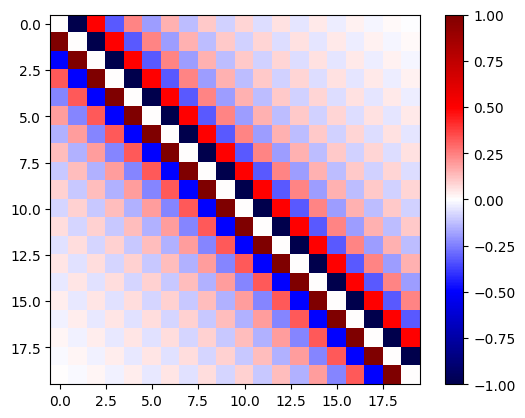

In [24]:
d = 20
z = arange(d)[:,newaxis]-arange(d)
imshow(L0(2*d,z), cmap = 'seismic',vmin=-1, vmax=1)
colorbar()
show()

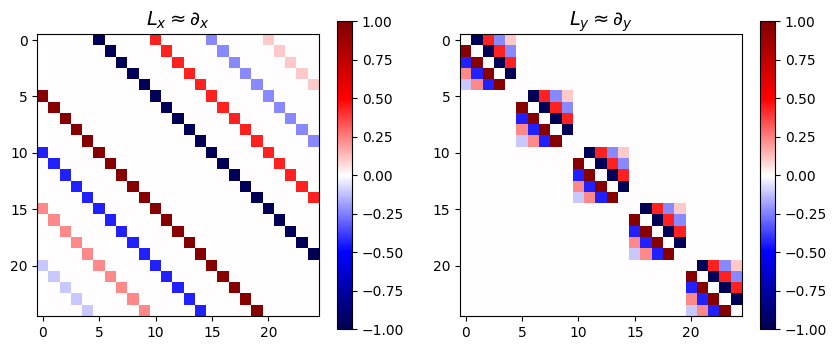

In [25]:
d = DIM
coords = mgrid[:d,:d] - d/2
x,y = coords.reshape((2,-1))

dx = (x[:,newaxis]-x) * (y[:,newaxis]==y) # make sure distance calculated only for the same y
dy = (y[:,newaxis]-y) * (x[:,newaxis]==x) # ... same x

figure(figsize=(10,4))
subplot(121)

Lx = L0(2*d,dx)
imshow(Lx,cmap = 'seismic',vmin=-1, vmax=1)
colorbar()
title(r'$L_x\approx \partial_x$',size=14)

subplot(122)

Ly = L0(2*d,dy)
imshow(Ly,cmap = 'seismic',vmin=-1, vmax=1)
colorbar()
title(r'$L_y\approx \partial_y$',size=14);


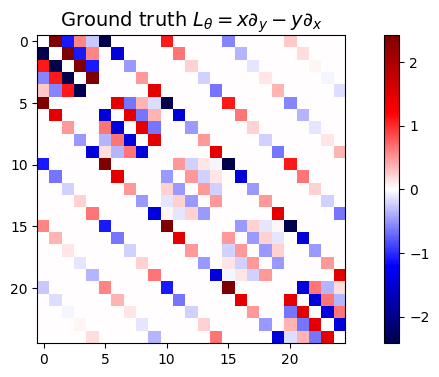

In [26]:

figure(figsize=(10,4))

yLx = diag(y) @ Lx
xLy = diag(x) @ Ly

L_rot = xLy - yLx
imshow(L_rot,cmap = 'seismic')#,vmin=-1, vmax=1)
colorbar()
title(r'Ground truth $L_\theta=x\partial_y-y\partial_x$', size = 14);

np.save('L_rot.npy', L_rot)

# Data

In [27]:
# dataset = CIFAR100
dataset = FixedRot #AugRotMNIST__0
# dataset = AugRotMNIST__0
num_targets = dataset.num_targets

batch_size = 32

test_batch_size = 1000
# device = torch.device("cuda")
device = torch.device("cpu")

train_kwargs = {'batch_size': batch_size}
test_kwargs = {'batch_size': test_batch_size}
if device.type =='cuda':
    cuda_kwargs = {'num_workers': 1,
                'pin_memory': True,
                'shuffle': True}
    train_kwargs.update(cuda_kwargs)
    test_kwargs.update(cuda_kwargs)

ang_n = 10
ang = pi/ang_n
dataset1 = dataset('../data', train=True, size=(DIM,DIM), angle=ang)
dataset2 = dataset('../data', train=False, size=(DIM,DIM), angle=ang)

train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)


50000 torch.Size([50000, 1, 5, 5])
10000 torch.Size([10000, 1, 5, 5])


/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/torch/nn/functional.py:4358: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(
/Users/elias/anaconda3/envs/sympde/lib/python3.10/site-packages/torch/nn/functional.py:4296: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn(


In [28]:
r=0 # r = 1e-2*torch.randn(*dataset1.data.shape)
X,Y = (dataset1.data-127.5)/255+r, (dataset1.data_rot-127.5)/255 +r
X,Y = X.view(X.shape[0], -1), Y.view(Y.shape[0], -1)  

## Learning $L_\theta$ from small rotations
Now we learn $L_\theta$ from pairs of images where one has a small, fixed rotation relative to the other. 
This is simply using L-conv for linear regression, trained via SGD.
\begin{align}
    F(h) &= h+ L_ih\bar{\epsilon}^i %= (I+L_ihM^i)\cr
    %M^i &= W^i [\tilde{W}^0]^{-1}
\end{align}

In [29]:
s = dataset1[0][0].shape
d = prod(s)
lc = Lconv_core(d=d,num_L=1, cin=1, cout=1)
model = nn.Sequential(
    nn.Flatten(2),
    lc,
    Reshape(s)
).to(device)

optimizer = optim.Adam(model.parameters(),lr = 1e-2)

t = Trainer(model, device, optimizer, train_loader=train_loader, test_loader=test_loader, 
            #dataset_class=AugRotMNIST__0, #dataset, 
            loss_func=F.mse_loss)

t.fit(30)


100%|██████████| 30/30 [00:12<00:00,  2.32it/s]


Text(0.5, 0, 'Epochs')

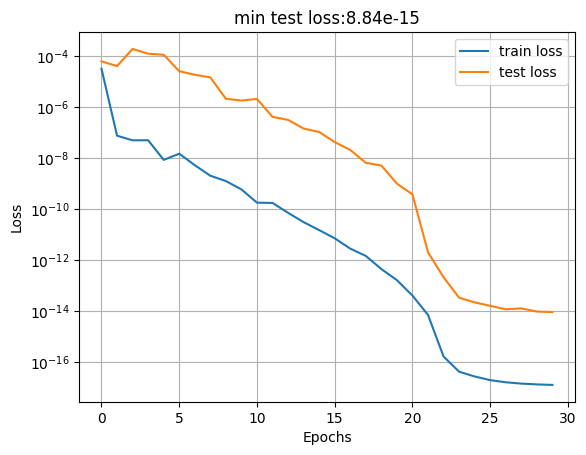

In [30]:
for k in ['train loss', 'test loss']:
    plot(t.history[k], label=k)
    
title(f'min test loss:{min(t.history["test loss"]):.3g}')
legend()
grid()
yscale('log')
ylabel('Loss')
xlabel('Epochs')

In [31]:
L_small = (lc.L*lc.Wi).detach().cpu().numpy()[0] / ang
lc.Wi

Parameter containing:
tensor([[[1.0176]]], requires_grad=True)

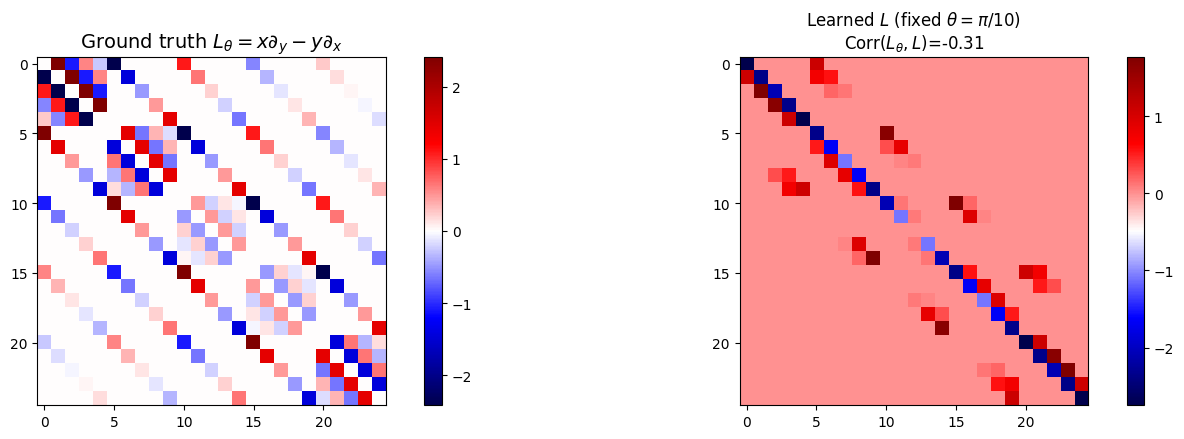

In [36]:
m = 3
vmin, vmax = -m, m
vmin, vmax = None, None

figure(figsize=(10*3/2,3*3/2))
subplot(121)
title(r'Ground truth $L_\theta=x\partial_y-y\partial_x$', size = 14);
imshow(L_rot, cmap='seismic', vmin = vmin, vmax = vmax)
colorbar()

subplot(122)
title(r'Learned $L$ (fixed $\theta=\pi/%d$)'%(ang_n)+\
      '\n'+r'Corr($L_\theta,L$)=%.2f'% coscorr(L_rot, L_small))
imshow(L_small, cmap='seismic', vmin = vmin, vmax = vmax)
colorbar()

tight_layout()